# Fundamenal modes of vibration of a simple building

Find the fundamental modes of vibration of a three storey building with four columns of stiffness $EI$ and height $h$, where each storey has mass $m$.

The equilibrium equation in terms of the stiffness and mass matrix is:
$$
\mathbf{M}\ddot{\mathbf{u}} + \mathbf{K}\mathbf{u} = \mathbf{0} \ , \quad
\mathbf{M} = \left[\begin{matrix}
m_1 & 0 & 0 \\
0 & m_2 & 0 \\
0 & 0 & m_3
\end{matrix}\right] \ , \quad
\mathbf{K} = \left[\begin{matrix}
k_1 + k_2 & -k_2 & 0 \\
-k_2 & k_2 + k_3 & -k_3 \\
0 & -k_3 & k_2 + k_3
\end{matrix}\right]
$$

Which trying test solutions as $\mathbf{u} = \mathbf{v}\sin(\omega t + \varphi)$ leads to a generalized eigenvalue problem of the type:

$$
\det[\mathbf{K} - \omega^2 \mathbf{M}] = 0
$$

| Geometry of the building |  |
|--------------------------|--|
| Number of stories | 3 to 5 |
| Columns | HEB200 ($\times 4$) |
| Young modulus | $200GPa$ |
| Storey height | $3m$ |
| Storey mass | $100Tn$ |

## Assembly of the matrices

First of all, the mass and stiffness matrices are built according to the given data.

In [ ]:
import numpy as np

n_stories = 5
m = 100*np.ones(n_stories)            # Tn
E = 2e8                               # KPa (steel)
I = 2e-5                              # m^4 (HEB200, weak axis)
h = 3                                 # m
k = 4*12*E*I/h**3*np.ones(n_stories)  # KN/m

M = np.zeros((n_stories, n_stories))
K = np.zeros((n_stories, n_stories))
M[0,0] = m[0]
K[0,0] = k[0]
for i in range(1,n_stories):
  M[i,i] += m[i]
  K[i,i] += k[i]
  K[i-1,i-1] += k[i]
  K[i,i-1] += -k[i]
  K[i-1,i] += -k[i]

## Solution of the eigenvalue problem

We eill use the already implemented function in `scipy` library. More options can be used when calling the library, such as computing only the desired evgenvalues passing the optional argument `eigvals=(0,n)`.

In [ ]:
from scipy.linalg import eigh
eigvals, eigvecs = eigh(K, M)

Normalization of the eigenvectors and computation of the frequencies. Note that the matrix of eigenvectors needs to be transposed.

In [ ]:
eigvecs_n = [v/max(abs(v)) for v in eigvecs.T]
frequencies = eigvals**0.5
periods = 2*np.pi/frequencies

### Modal analysis

For each mode of deformation, the *modal mass* is defined as
$$
m_i = \frac{\mathbf{v}_i^T \mathbf{M} \mathbf{v}_i}{\mathbf{v}_i^T\mathbf{v}_i}
$$

Another important concept is the *partcipative* or *effective mass*. It is defined considering the structure under a general earthquake defined by a direction $\mathbf{d}$. The unid vector $\mathbf{d}$ is applied as unit displacement for all the nodes. Thus, this yields the definition of the *effective mass*
$$
M_i = \frac{(\mathbf{v}_i^T \mathbf{M} \mathbf{d})^2}{\mathbf{v}_i^T \mathbf{M} \mathbf{v}_i}
$$

It verifies that the sum of the modal or the effective masses are equal to the total mass of the building:
$$
\sum_i m_i = \sum_i M_i = M = \text{trace}(\mathbf{M})
$$


In [ ]:
d = np.ones(n_stories)
modal_mass = [(v@M@v) / (v@v) for v in eigvecs_n] # eigvecs.T
participation = [(v@M@d) / (v@M@v) for v in eigvecs_n] # eigvecs.T
eff_mass = [(v@M@d)**2 / (v@M@v) for v in eigvecs_n] # eigvecs.T
eff_mass_rel = eff_mass / np.trace(M)
print(d)
print(eff_mass)
print(participation)

[1. 1. 1. 1. 1.]
[439.76500071552937, 43.588747992605114, 12.107799937954209, 3.7546648324995684, 0.7837865214116784]
[1.251701699101634, -0.3940739326576878, 0.20769360695877934, 0.11565811182933916, -0.05284323611176283]


## Graphical representation of the solution

For graphical purpose, an extra node with null displacement has been added to the deformations vector. This node corresponds to the base level. 

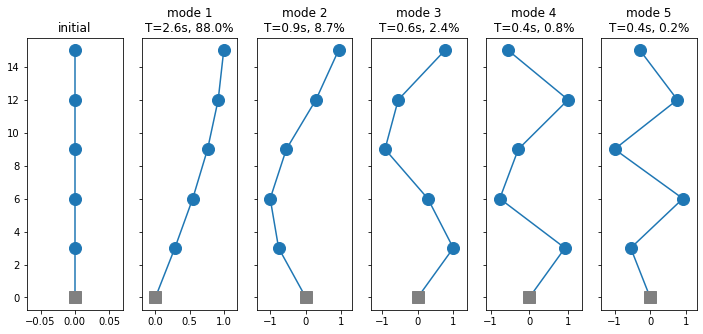

In [ ]:
import matplotlib.pyplot as plt

z = np.arange(0, n_stories+1)*h  # vertical position of the stories. There is an extra position for the base level
fig, ax = plt.subplots(1,n_stories+1, sharey=True, figsize=(12,5))

def plot_mode(v,i,title):
  ax[i].plot(v,z, marker='o', markersize=12)
  ax[i].plot(0,0, marker='s', markersize=12, markeredgecolor='gray', markerfacecolor='gray')
  ax[i].set_title(title)
  ax[i].margins(x=.2)

plot_mode(np.zeros(n_stories+1),0,'initial')

n_modes = n_stories
for i in range(n_modes):
  vi = eigvecs_n[i]
  vi = np.insert(vi,0,0)    # we add a zero displacement at the base level
  legend = f'mode {i+1}\nT={periods[i]:.1f}s, {eff_mass_rel[i]:.1%}'
  plot_mode(vi,i+1,legend)

plt.show()